In [4]:

%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
import os

if ".." not in sys.path:
    sys.path.append("..")

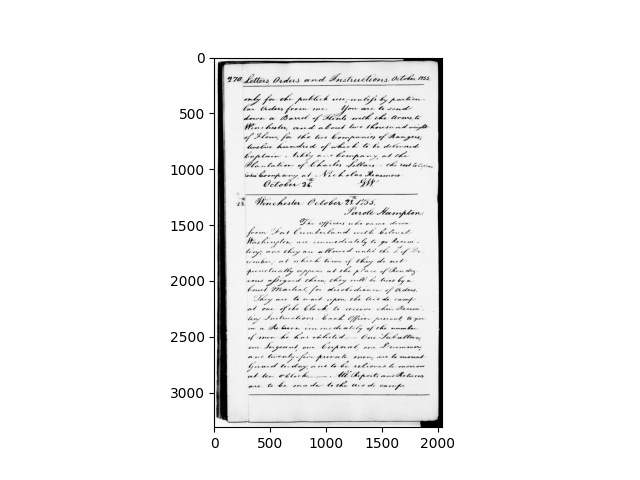

In [20]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

image = "2700270"
imagePath = f"./gw/pages/{image}.png"
gtPath = f"./gw/ground_truth/{image}.gtp"
hgtPath = f"./gw/heuristic_ground_truth/{image}.gtp"

imageFile = Image.open(imagePath)

# Für später folgende Verarbeitungsschritte muss das Bild mit float32-Werten vorliegen.
im_arr = np.asarray(imageFile)
doc_height , doc_width = im_arr.shape
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im_arr, cmap=cm.get_cmap('Greys_r'))


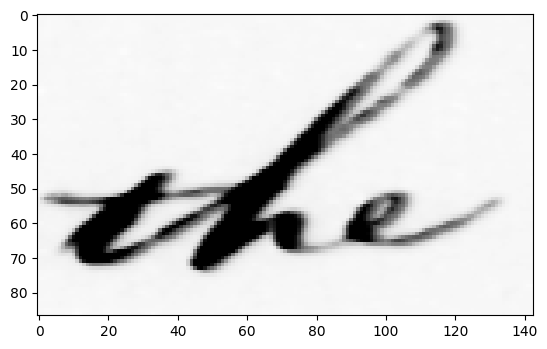

In [2]:
# load test image
labels = open(gtPath ,"r")
wordTheLine = labels.read().split("\n")[9].split(" ")
y1 , x1 , y2 , x2 = int(wordTheLine[0]) , int(wordTheLine[1]) , int(wordTheLine[2]) , int(wordTheLine[3])
testing_word_arr = im_arr[x1:x2, y1:y2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr, cmap=cm.get_cmap('Greys_r'))

In [8]:
# compute the features of the test image 
from scipy.cluster.vq import kmeans2
from common.features import compute_sift_descriptors

testing_word_frames ,testing_word_desc  = compute_sift_descriptors(testing_word_arr)
page_frames ,page_desc  = compute_sift_descriptors(im_arr)
n_centroids = 100 
# create a cluster of the full image
_, labels = kmeans2(page_desc, n_centroids, iter=20, minit='points')

print(len(page_frames))

16932


<BarContainer object of 100 artists>

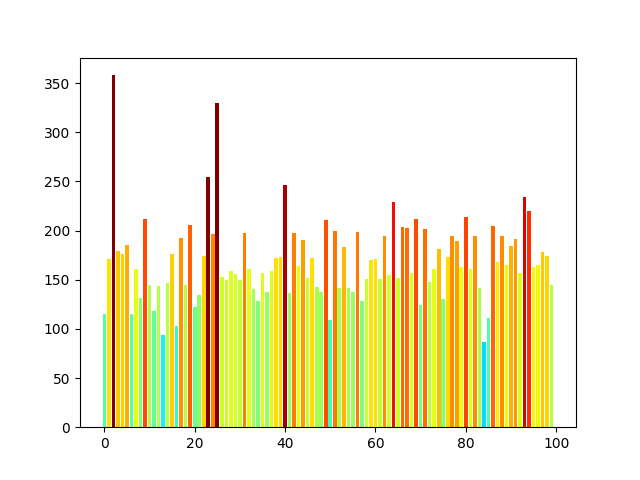

In [9]:
# compute the bag of features
bin_count = np.bincount(labels,minlength = n_centroids)
bin_count

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = cm.get_cmap('jet')
ax.bar(list(range(n_centroids)) , bin_count , color = [colormap(bin) for bin in bin_count])

sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=319, x2=406, y1=580, y2=723


<BarContainer object of 26 artists>

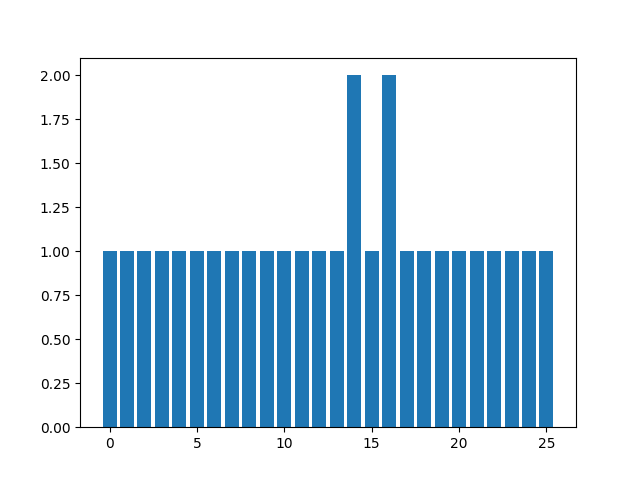

In [29]:
# takes a position of a grid in the image and uses the cluster of sift desc to calculate the bag of features histgramm
def get_bag_of_words_histogram(sift_descriptors , page_frames , labels , x1 , x2 , y1 , y2):
	# sift_descriptors: the sift descriptors of the full image
	# sift_descriptors_positions: the positions of the sift descriptors in the full image
	# sift_descriptors_labels_array: an array that contains a label for each sift descriptors
	# x1,x2,y1,y2: the positions of the frame

	# the function works as follows:
		# go over all descriptors inside the frame
		# for each one of them get its label
		# increment a counter for each label
		# return the histogram
		# the histogram is a map of this form {'label' : count} e.g {'f1' : 4} means that the label f1 is coming 4 times inside the frame
	assert sift_descriptors.shape[0] == len(page_frames) and len(page_frames) == labels.shape[0] , "wrong vars"
	print("sift_descriptors shape" , sift_descriptors.shape)
	print("page_frames shape" , len(page_frames))
	print("labels shape" , labels.shape)
	print(f"x1={x1}, x2={x2}, y1={y1}, y2={y2}")

	label_to_count = {}
	for desc , frame , label in zip(sift_descriptors , page_frames , labels):
		if frame[1] < x1 or frame[1] > x2 or frame[0] < y1 or frame[0]  > y2:
			continue
		label_to_count[label] = label_to_count.get(label , 0) + 1
	return label_to_count


# # bag of features histogram for the request image
request_image_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , x1 , x2 , y1 , y2)

print(request_image_histogram)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(request_image_histogram)), list(request_image_histogram.values()), align='center')


In [27]:

window_histograms = [] # array of dicts {"window" : [x1,y1,x2,y2] , "histogram" : ...}

# # bag of features histograms for the frames 
frame_width = x2 - x1
frame_height = y2 - y1
step_size_x = frame_width
step_size_y = frame_height
frame_x1 = 0
frame_y1 = 0
frame_x2 = frame_x1 + frame_width
frame_y2 = frame_y1 + frame_height

while True:
	print("compute histogram for window x1,y1,x2,y2" ,frame_x1 , frame_y1 , frame_x2 , frame_y2 )
	# do operation on the window
	window_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , frame_x1 , frame_x2 , frame_y1 , frame_y2)
	window_histograms.append({"window" : [frame_x1 , frame_y1 , frame_x2 , frame_y2] , "histogram" : window_histogram})

	# update the window to the left
	frame_x1 += step_size_x
	frame_x2 = frame_x1 + frame_width

	# if we are at the end to the most far right. go down 
	if frame_x2 > doc_width: 
		frame_x1 = 0
		frame_x2 = frame_x1 + frame_width
		frame_y1 += step_size_y
		frame_y2 = frame_y1 + frame_height
	
	# if we are done. break
	if frame_y2 > doc_height:
		break


compute histogram for window x1,y1,x2,y2 0 0 87 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=0, x2=87, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 87 0 174 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=87, x2=174, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 174 0 261 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=174, x2=261, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 261 0 348 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=261, x2=348, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 348 0 435 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=348, x2=435, y1=0, y2=143
compute histogram for window x1,y1,x2,y2 435 0 522 143
sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=435, x2=522, y1=0, y2=143
compute hist

In [28]:
print(window_histograms)

[{'window': [0, 0, 87, 143], 'histogram': {16: 1, 89: 2, 59: 1, 15: 1, 1: 1, 55: 1, 4: 1, 83: 1, 42: 1, 53: 1, 61: 1, 46: 2, 69: 4, 17: 1, 48: 1, 51: 1, 40: 1, 54: 1, 60: 2, 25: 2, 79: 1}}, {'window': [87, 0, 174, 143], 'histogram': {39: 2, 30: 2, 35: 1, 15: 1, 4: 5, 57: 1, 72: 1, 8: 1, 46: 1, 61: 1, 5: 5, 56: 5, 93: 1, 54: 2, 29: 2, 1: 1, 94: 1, 41: 1, 23: 1}}, {'window': [174, 0, 261, 143], 'histogram': {89: 1, 20: 1, 35: 1, 57: 3, 4: 4, 61: 1, 40: 1, 5: 4, 56: 3, 66: 1, 86: 2, 9: 1, 48: 1, 97: 1, 53: 1, 98: 1, 2: 1}}, {'window': [261, 0, 348, 143], 'histogram': {15: 1, 57: 3, 59: 1, 37: 1, 4: 4, 72: 1, 70: 1, 5: 8, 9: 1, 54: 1, 26: 1, 34: 2, 60: 1, 14: 1, 38: 1}}, {'window': [348, 0, 435, 143], 'histogram': {36: 1, 37: 1, 89: 3, 4: 5, 40: 4, 92: 1, 5: 11, 29: 2, 45: 1, 41: 2, 73: 1, 1: 1, 80: 1, 63: 1}}, {'window': [435, 0, 522, 143], 'histogram': {96: 1, 57: 1, 89: 1, 20: 1, 4: 4, 40: 4, 5: 8, 66: 1, 29: 1, 7: 1, 56: 1, 81: 1, 79: 1, 77: 1, 53: 1}}, {'window': [522, 0, 609, 143], '